Classify using Deep Learning

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, accuracy_score

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [3]:
inoutpath = '/home/xiaopengxu/Desktop/data-covid-review/2021-05-11/'

train_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_train.csv'
test_data_path = inoutpath + 'features.ori_doc2vec_deepwalk_scores_test.csv'

dl_layers = [100, 30, 50]

epochs = 10

## Load data

In [5]:
def load_data(compdata_path):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Loading data ...")
    papers = pd.read_csv(compdata_path, index_col=False)
    papers.drop(['Unnamed: 0'], axis=1, inplace=True)

    return papers.fillna(0)

In [6]:
X = load_data(train_data_path)
X_30d = load_data(test_data_path)

2021-05-15 13:36:30.274128: Loading data ...
2021-05-15 13:36:31.014792: Loading data ...


/home/xiaopengxu/anaconda3/envs/ml-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (3,4,7) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [7]:
y = X.is_published
y_30d = X_30d.is_published

In [8]:
print(X.columns.values)

['title' 'abstract' 'journal' 'DOI' 'date' 'collection' 'published'
 'nauthors' 'keywords' 'topic.Drug discovery' 'topic.Clinics'
 'topic.Healthcare' 'topic.Imaging' 'topic.Genomics' 'topic.Epidemiology'
 'topic' 'ref' 'p_doi' 'dv 1' 'dv 2' 'dv 3' 'dv 4' 'dv 5' 'dv 6' 'dv 7'
 'dv 8' 'dv 9' 'dv 10' 'dv 11' 'dv 12' 'dv 13' 'dv 14' 'dv 15' 'dv 16'
 'dv 17' 'dv 18' 'dv 19' 'dv 20' 'dv 21' 'dv 22' 'dv 23' 'dv 24' 'dv 25'
 'dv 26' 'dv 27' 'dv 28' 'dv 29' 'dv 30' 'dv 31' 'dv 32' 'dv 33' 'dv 34'
 'dv 35' 'dv 36' 'dv 37' 'dv 38' 'dv 39' 'dv 40' 'dv 41' 'dv 42' 'dv 43'
 'dv 44' 'dv 45' 'dv 46' 'dv 47' 'dv 48' 'dv 49' 'dv 50' 'dw 1' 'dw 2'
 'dw 3' 'dw 4' 'dw 5' 'dw 6' 'dw 7' 'dw 8' 'dw 9' 'dw 10' 'dw 11' 'dw 12'
 'dw 13' 'dw 14' 'dw 15' 'dw 16' 'dw 17' 'dw 18' 'dw 19' 'dw 20' 'dw 21'
 'dw 22' 'dw 23' 'dw 24' 'dw 25' 'dw 26' 'dw 27' 'dw 28' 'dw 29' 'dw 30'
 'dw 31' 'dw 32' 'dw 33' 'dw 34' 'dw 35' 'dw 36' 'dw 37' 'dw 38' 'dw 39'
 'dw 40' 'dw 41' 'dw 42' 'dw 43' 'dw 44' 'dw 45' 'dw 46' 'dw 47' 'dw 4

## Train DL model

In [9]:
def create_model(n_features, layers):
    # create model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(layers[0], input_dim=n_features, activation='relu'))

    # add hidden layers
    for i in range(1, len(layers)):
        model.add(tf.keras.layers.Dense(layers[i], activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=["accuracy"])
    return model

In [10]:
def eval_pred(y_true, y_prob):

    y_pred = y_prob >= 0.5
    
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_s = auc(fpr, tpr)

    prec, recall, f1_s, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    acc = accuracy_score(y_true, y_pred)
    
    print("AUC = %.3f, precision = %.3f, recall = %.3f, accuracy = %.3f, f1_score = %.3f" % (auc_s, prec, recall, acc, f1_s))

In [32]:
def dl_modeling(model_name, save_path, X_train, X_test, y_train, y_test, features, layers, epochs=10, batch_size=64):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Training {} model ...".format(model_name))
    model = create_model(len(features), layers)
    md = model.fit(X_train[features], y_train, epochs=epochs, batch_size=64)
    model.save(save_path + "model." + model_name + ".dl")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Evaluating {} model ...".format(model_name))
    y_test_prob = model.predict(X_test[features])
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auc_dl = auc(fpr, tpr)
    eval_pred(y_test, y_test_prob)
    
    return fpr, tpr, auc_dl

In [37]:
def draw_ROC_figure(fprs, tprs, f_names, aucs, save_path):
    plt.figure()
    plt.rcParams['figure.figsize'] = [10, 10]
    
    for i in range(len(f_names)):
        plt.plot(fprs[i], tprs[i], label= f_names[i] +', AUC={:.4f}'.format(aucs[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    fig1 = plt.gcf()
    plt.draw()
    fig1.savefig(save_path + "figs_dl_features_rocs.pdf")

In [43]:
def feature_comparison(X, y, save_path, epochs=10):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
    em_size = 50
    F_Doc2Vec = ['dv ' + str(i + 1) for i in range(em_size)]
    F_DeepWalk = ['dw ' + str(i + 1) for i in range(em_size)]
    F_ascore = ['auth.papers.score', 'auth.citations.score', 'art.citations.score', 'art.views.score', 'final.score']
    
    f_names = ['Doc2Vec', 'DeepWalk', 'Ascore', 'Doc2Vec+DeepWalk+AScore']
    f_combs = [F_Doc2Vec, F_DeepWalk, F_ascore,  F_Doc2Vec + F_DeepWalk + F_ascore]
    layers = [[120, 80, 40, 20], [120, 70, 50], [100, 30, 50], [100, 30, 50]]
    
    fprs, tprs, aucs = [], [], []
    
    for i in range(len(f_names)):
        fpr, tpr, auc = dl_modeling(f_names[i], save_path, X_train, X_test, y_train, y_test, f_combs[i], layers[i], epochs=epochs)
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc)
        
    draw_ROC_figure(fprs, tprs, f_names, aucs, save_path)

2021-05-15 14:32:59.289490: Training Doc2Vec model ...
Epoch 1/10
159/159 [==============================] - 1s 2ms/step - loss: 0.5597 - accuracy: 0.7216
Epoch 2/10
159/159 [==============================] - 0s 2ms/step - loss: 0.5053 - accuracy: 0.7545
Epoch 3/10
159/159 [==============================] - 0s 2ms/step - loss: 0.4744 - accuracy: 0.7678
Epoch 4/10
159/159 [==============================] - 0s 2ms/step - loss: 0.4647 - accuracy: 0.7756
Epoch 5/10
159/159 [==============================] - 0s 2ms/step - loss: 0.4345 - accuracy: 0.7959
Epoch 6/10
159/159 [==============================] - 0s 2ms/step - loss: 0.4035 - accuracy: 0.8122
Epoch 7/10
159/159 [==============================] - 0s 2ms/step - loss: 0.3751 - accuracy: 0.8308
Epoch 8/10
159/159 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.8510
Epoch 9/10
159/159 [==============================] - 0s 2ms/step - loss: 0.3035 - accuracy: 0.8692
Epoch 10/10
159/159 [========================

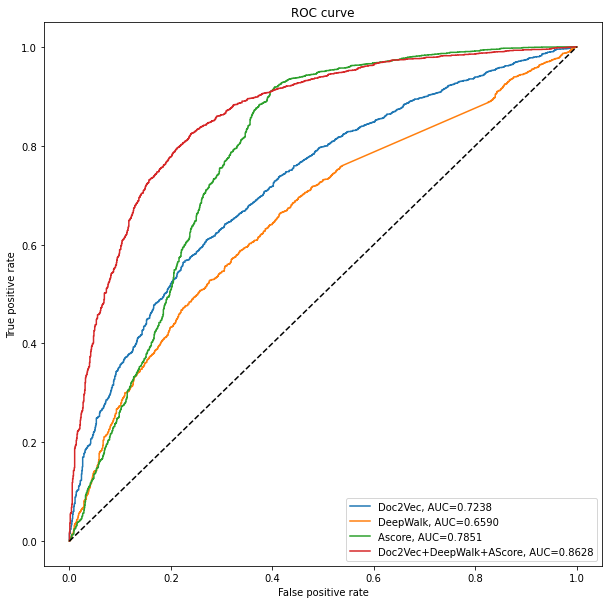

In [44]:
feature_comparison(X, y, inoutpath, epochs=epochs)

## Analyze prediction among Topics

In [ ]:
def dl_modeling(model_name, save_path, X_train, X_test, y_train, y_test, features, layers, epochs=10, batch_size=64):
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Training {} model ...".format(model_name))
    model = create_model(len(features), layers)
    md = model.fit(X_train[features], y_train, epochs=epochs, batch_size=64)
    model.save(save_path + "model." + model_name + ".dl")

    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f') + ": Evaluating {} model ...".format(model_name))
    y_test_prob = model.predict(X_test[features])
    
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    auc_dl = auc(fpr, tpr)
    eval_pred(y_test, y_test_prob)
    
    return fpr, tpr, auc_dl

<AxesSubplot:xlabel='topic'>

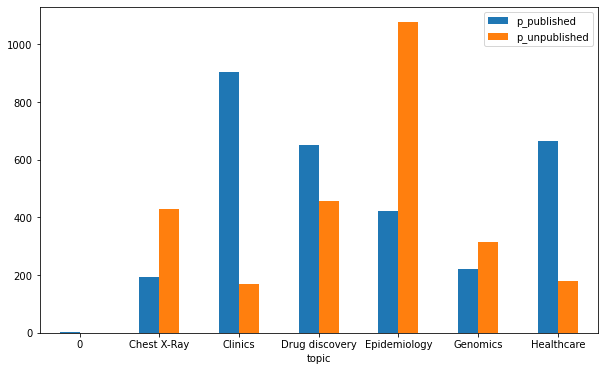

In [37]:
plt.rcParams['figure.figsize'] = [10, 6]

X['p_published'] = (X['pub_prob'] > 0.5) * 1
df_ret = pd.merge(X['topic'], X['p_published'], left_index=True, right_index=True)

topic_sum = df_ret.groupby('topic').agg({'topic':'count', 'p_published':'sum'})
topic_sum['p_unpublished'] = topic_sum['topic'] - topic_sum['p_published']
topic_sum[['p_published', 'p_unpublished']].plot.bar(rot=0)

<AxesSubplot:xlabel='topic'>

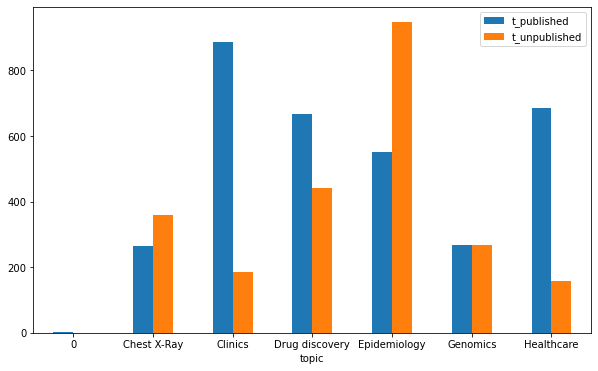

In [38]:
X['t_published'] = y * 1
df_t_ret = pd.merge(X['topic'], X['t_published'], left_index=True, right_index=True)

topic_t_sum = df_t_ret.groupby('topic').agg({'topic':'count', 't_published':'sum'})
topic_t_sum['t_unpublished'] = topic_t_sum['topic'] - topic_t_sum['t_published']
topic_t_sum[['t_published', 't_unpublished']].plot.bar(rot=0)